In [1]:
import sys
import os

import torch
import random
import warnings
import time

import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
import torchvision
import torchvision.transforms.functional as TF
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import Convolve
from scipy.ndimage import gaussian_filter1d
from cca_zoo.linear import rCCA
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

# Import MI files
from utils import *
from models import *
from estimators import *
from trainers import *

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['figure.dpi'] = 100

# Set global font sizes for better readability
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.titlesize': 18})
plt.rcParams.update({'axes.labelsize': 16})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'ytick.labelsize': 15})
plt.rcParams.update({'legend.fontsize': 15})

# Directories
main_dir = os.getcwd()
model_cache_dir = os.path.join(main_dir, '..', 'model_cache')

# Set default type now
default_dtype = torch.float32
torch.set_default_dtype(default_dtype)

# Directories
data_dir = os.path.join(os.getcwd(), '..', '..', 'localdata', 'data_for_python')

/Users/leo/Desktop/ResearchPhD/VNCMP/analysis_VNCMP/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import traceback
import weakref

# Dictionary to store creation info
tensor_creation_info = {}#weakref.WeakKeyDictionary()

# Store original tensor creation functions
original_tensor = torch.tensor
original_zeros = torch.zeros
original_ones = torch.ones
original_empty = torch.empty

def track_tensor_creation(original_func):
    def wrapper(*args, **kwargs):
        tensor = original_func(*args, **kwargs)
        # Store creation stack trace
        tensor_creation_info[id(tensor)] = {
            'stack': traceback.format_stack(),
            'function': original_func.__name__
        }
        return tensor
    return wrapper

# Patch the functions
torch.tensor = track_tensor_creation(original_tensor)
torch.zeros = track_tensor_creation(original_zeros)
torch.ones = track_tensor_creation(original_ones)
torch.empty = track_tensor_creation(original_empty)

# To-do list:
Main:
- [X] Fix Xnoise vs X in trainers, make consistent
- [X] Implement precision functions


Low priority:
- [] Try ISI encoding instead (as in https://pmc.ncbi.nlm.nih.gov/articles/PMC9870156/)
- [/] Parallel training with shared memory, fixed to have the right number of processes


In [2]:
# Check if CUDA or MPS is running
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = "CPU"

print(f'Device: {device}')

Device: mps


0.2474842071533203
Neurons (X): torch.Size([32, 3876107])
Muscles (Y): torch.Size([10, 3876107])
Neuron Labels: ['87', '29', '1', '78', '12', '20', '2', '6', '41', '11', '13', '65', '89', '15', '75', '42', '33', '28', '14', '39', '21', '7', '96', '68', '8', '88', '93', '26', '10', '0', '30', '3']
Muscle Labels: ['rsa', 'rdvm', 'lba', 'ldvm', 'rdlm', 'lsa', 'rax', 'lax', 'rba', 'ldlm']


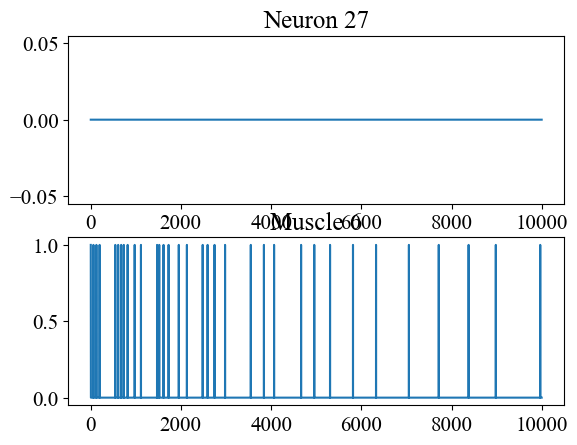

In [3]:
# Read the data and apply some binning/downsampling
period = 0.0001
tic = time.time()
X, Y, x_labels, y_labels = read_spike_data(os.path.join(data_dir, '2025-03-21'), period)
# Convert to torch tensors
X, Y = torch.tensor(X, dtype=default_dtype), torch.tensor(Y, dtype=default_dtype)
print(time.time() - tic)

print(f"Neurons (X): {X.shape}")
print(f"Muscles (Y): {Y.shape}") 
print("Neuron Labels:", x_labels)
print("Muscle Labels:", y_labels)

# Plot sample of activity
pl = 10000
useneuron, usemuscle = np.random.choice(X.shape[0]), np.random.choice(Y.shape[0])
idx = torch.nonzero(Y[usemuscle,:] > 0)[0][0]
fig, ax = plt.subplots(2, 1)
ax[0].plot(X[useneuron,idx:idx+pl])
ax[1].plot(Y[usemuscle,idx:idx+pl])
ax[0].set_title(f'Neuron {useneuron}')
ax[1].set_title(f'Muscle {usemuscle}')
fig.show()

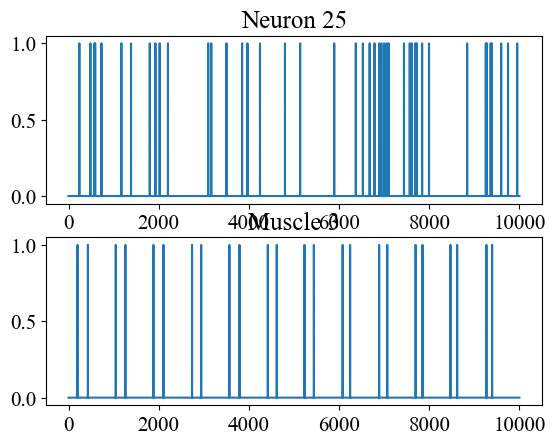

In [4]:
pl = 10000
useneuron, usemuscle = np.random.choice(X.shape[0]), np.random.choice(Y.shape[0])
useneuron = 25
# idx = np.random.choice(torch.nonzero(Y[usemuscle,:] > 0)[0])
idx = np.random.choice(torch.nonzero(Y[usemuscle,:] > 0).flatten())
fig, ax = plt.subplots(2, 1)
idx = idx + 4000
ax[0].plot(X[useneuron,idx:idx+pl])
ax[1].plot(Y[usemuscle,idx:idx+pl])
ax[0].set_title(f'Neuron {useneuron}')
ax[1].set_title(f'Muscle {usemuscle}')
fig.show()

In [ ]:
params = {
    # Optimizer parameters (for training)
    'epochs': 250,
    'window_size': 512, # Window of time the estimator operates on, in samples
    'batch_size': 128, # Number of windows estimator processes at any time
    'learning_rate': 5e-3,
    'n_trials': 3,
    'patience': 10,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.9,
    # Critic parameters for DSIB or DVSIB (for the estimator), except embed_dim, which changes with training
    'model_func': DSIB, # DSIB or DVSIB
    'layers': 4,
    'fc_layers': 2, # fully connected layers, only for if using CNNs from data_form: 'image' 
    'hidden_dim': 256,
    'activation': nn.LeakyReLU, #nn.Softplus
    'beta': 512,
    'max_dz': 12, # max value for embed_dim that we search for
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'data_form': 'image',
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 1000, # If input has more than this many batches, encoder runs are split up for memory management
}

In [ ]:
torch.mps.empty_cache()
neuron = np.random.choice(X.shape[0])
neuron = 25
print(f'Neuron {neuron}')
this_params = {**params, 'embed_dim': 10}
dataset = BatchedDataset(X[[neuron],:].to(device), Y.to(device), this_params['window_size'])
# mis, mis_test, mod = train_cnn_model(dataset, this_params)
mis_test, train_id = train_cnn_model_no_eval(dataset, this_params, model_cache_dir)
mod = retrieve_best_model(model_cache_dir, mis_test, this_params, train_id=train_id, burn_in=1)


Neuron 25
Train time = 5.775474786758423
Test time = 0.24387192726135254
Epoch: 1, DSIB, test: 0.001490626367740333
Train time = 3.781615972518921
Test time = 0.10401201248168945
Epoch: 2, DSIB, test: 0.0032741264440119267
Train time = 3.767526865005493
Test time = 0.1042170524597168
Epoch: 3, DSIB, test: 0.014530785381793976
Train time = 3.861485004425049
Test time = 0.10765218734741211
Epoch: 4, DSIB, test: 0.06576761603355408
Train time = 3.7685561180114746
Test time = 0.10485291481018066
Epoch: 5, DSIB, test: 0.07053261250257492
Train time = 3.777069091796875
Test time = 0.10352206230163574
Epoch: 6, DSIB, test: 0.07763534039258957
Train time = 3.770236015319824
Test time = 0.10445523262023926
Epoch: 7, DSIB, test: 0.06648082286119461
Train time = 3.7765591144561768
Test time = 0.10422706604003906
Epoch: 8, DSIB, test: 0.046533290296792984
Train time = 3.8732051849365234
Test time = 0.1546030044555664
Epoch: 9, DSIB, test: 0.10662282258272171
Train time = 3.8265159130096436
Test ti

Text(0, 0.5, 'MI')

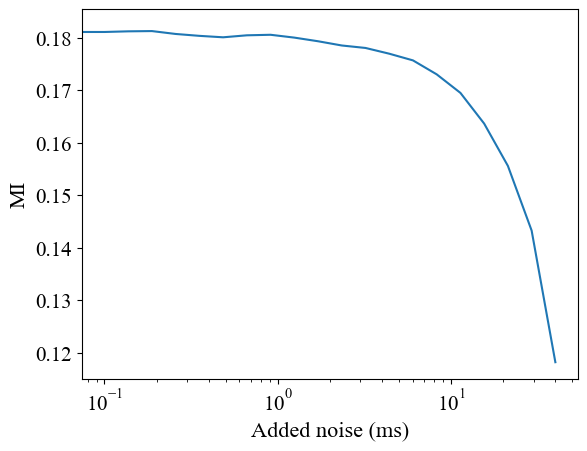

In [6]:
precision_noise_levels = np.hstack((0, np.logspace(np.log10(period), np.log10(0.04), 20) / period))
n_repeats = 3
with torch.no_grad():
    dataset = BatchedDatasetWithNoise(X[[neuron],:].to(device), Y.to(device), this_params['window_size'])
    precision_mi = np.zeros((len(precision_noise_levels), n_repeats))
    for j0,prec_noise_amp in enumerate(precision_noise_levels):
        for j1 in range(n_repeats):
            dataset.apply_noise(prec_noise_amp)
            precision_mi[j0,j1] = - mod(dataset.Xnoise, dataset.Ynoise).detach().cpu().numpy()

fig, ax = plt.subplots()
ax.plot(precision_noise_levels * period * 1000, np.mean(precision_mi, axis=1))
ax.set_xscale('log')
ax.set_xlabel('Added noise (ms)')
ax.set_ylabel('MI')

(0.0, 0.10468171461252496)

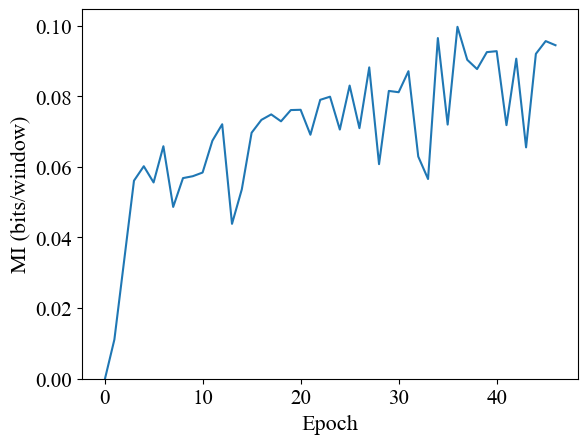

In [7]:
sigma = 1
# plt.plot(mis)
plt.plot(mis_test)
# plt.plot(gaussian_filter1d(mis, sigma=sigma) * np.log2(np.e) / (0.0005 * 512))
# plt.plot(gaussian_filter1d(mis_test, sigma=sigma) * np.log2(np.e) / (0.0005 * 512))
plt.xlabel('Epoch')
plt.ylabel('MI (bits/window)')
plt.ylim(0)

# How much does network architecture matter?

Test of different architectures. Saves precision_mi curves for each

Vary across filters per layer (8, 16, 32), n_layers (4,5), stride (1, 2, 3)

All neurons, single neuron

Networks:
- Branched first layer: 3x3 + dilated 3x3, other layers are normal 3x3
- Completely branched, all layers. 
- Same all layers

In [4]:
params = {
    # Optimizer parameters (for training)
    'epochs': 250,
    'window_size': 512, # Window of time the estimator operates on, in samples
    'batch_size': 128, # Number of windows estimator processes at any time
    'learning_rate': 5e-3,
    'n_trials': 3,
    'patience': 10,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.9,
    # Critic parameters for the estimator
    'model_func': DSIB, # DSIB or DVSIB
    'branch': '1', # Whether to have branched first layer '1', all branched layers 'all', or None if no branch layers
    'stride': 1, # stride of CNN layers. First layer will always be stride=1
    'n_filters': 32, # Number of new filters per layer. Each layer will 2x this number
    'layers': 4,
    'fc_layers': 2, # fully connected layers
    'hidden_dim': 256,
    'activation': nn.LeakyReLU, #nn.Softplus
    'embed_dim': 10,
    'beta': 512,
    'max_dz': 12, # max value for embed_dim that we search for
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 256, # If input has more than this many batches, encoder runs are split up for memory management
}

In [6]:
import gc
total = 0
torch.mps.empty_cache()
for obj in gc.get_objects():
    try:
        # if (not isinstance(obj, torch.nn.parameter.Parameter)) and (torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data))):
        if torch.is_tensor(obj) and not isinstance(obj, torch.nn.parameter.Parameter):
            print(type(obj), obj.size())
            # totalsize = np.sum(np.array([s for s in obj.size()]))
            if obj.nelement() < 1000:
                total += (obj.nelement() * obj.element_size())
            # if obj.size() == torch.Size([128]):
            #     bob = obj
    except:
        pass

<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([32, 3876107])
<class 'torch.Tensor'> torch.Size([10, 3876107])
<class 'torch.Tensor'> torch.Size([13555, 1])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([7570, 1, 1, 512])
<class 'torch.Tensor'> torch.Size([7570, 1, 10, 512])
<class 'torch.Tensor'> torch.Size([29095])
<class 'torch.Tensor'> torch.Size([29095])
<class 'torch.Tensor'> torch.Size([29095])
<class 'torch.Tensor'> torch.Size([29095])
<class 'torch.Tensor'> torch.Size([98648])
<class 'torch.Tensor'> torch.Size([98648])
<class 'torch.Tensor'> torch.Size([98648])
<class 'torch.Tensor'> torch.Size([98648])
<class 'torch.Tensor'> torch.Size([1, 3876107])
<class 'torch.Tensor'> torch.Size([10, 3876107])
<class 'torch.Tensor'> torch.Size([4])
<class 'torch.Tensor'> torch.Size([4])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([4])
<class 'torch.Tensor'> torch.Size([4])
<class 'torch.Tensor'> torch.Size([])


In [ ]:
tensor_creation_info[id(bob)]

Train time = 1.7911128997802734
Test time = 0.1670076847076416
Epoch: 1, DSIB, test: 0.0013586822897195816
Train time = 0.9563238620758057
Test time = 0.01839590072631836
Epoch: 2, DSIB, test: 0.057875797152519226
Train time = 1.124377965927124
Test time = 0.023164033889770508
Epoch: 3, DSIB, test: 0.08408087491989136
Train time = 0.9399838447570801
Test time = 0.01899099349975586
Epoch: 4, DSIB, test: 0.07898809760808945
Train time = 0.9606838226318359
Test time = 0.019114017486572266
Epoch: 5, DSIB, test: 0.09986978024244308
Train time = 0.9506821632385254
Test time = 0.017774105072021484
Epoch: 6, DSIB, test: 0.09865375608205795
Train time = 0.9309618473052979
Test time = 0.017596006393432617
Epoch: 7, DSIB, test: 0.09848124533891678
Train time = 0.9410088062286377
Test time = 0.017770051956176758
Epoch: 8, DSIB, test: 0.09007454663515091
Train time = 0.966465950012207
Test time = 0.019308090209960938
Epoch: 9, DSIB, test: 0.0784434899687767
Train time = 0.9637041091918945
Test time

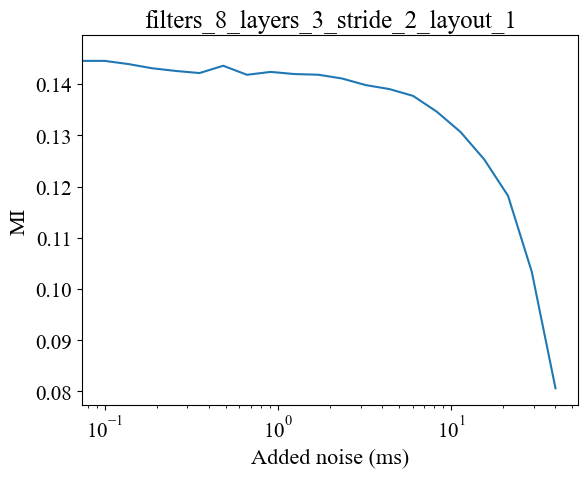

Train time = 1.6913080215454102
Test time = 0.08783292770385742
Epoch: 1, DSIB, test: 0.01735793985426426
Train time = 1.345602035522461
Test time = 0.038397789001464844
Epoch: 2, DSIB, test: 0.06432433426380157
Train time = 1.3691670894622803
Test time = 0.040419816970825195
Epoch: 3, DSIB, test: 0.061099790036678314
Train time = 1.3661048412322998
Test time = 0.03291606903076172
Epoch: 4, DSIB, test: 0.08838090300559998
Train time = 1.3751132488250732
Test time = 0.03871893882751465
Epoch: 5, DSIB, test: 0.08385170996189117
Train time = 1.3730831146240234
Test time = 0.031555891036987305
Epoch: 6, DSIB, test: 0.10277846455574036
Train time = 1.3867757320404053
Test time = 0.0389101505279541
Epoch: 7, DSIB, test: 0.09978034347295761
Train time = 1.3838882446289062
Test time = 0.03401613235473633
Epoch: 8, DSIB, test: 0.09542008489370346
Train time = 1.3674519062042236
Test time = 0.03892993927001953
Epoch: 9, DSIB, test: 0.11084718257188797
Train time = 1.4002280235290527
Test time = 

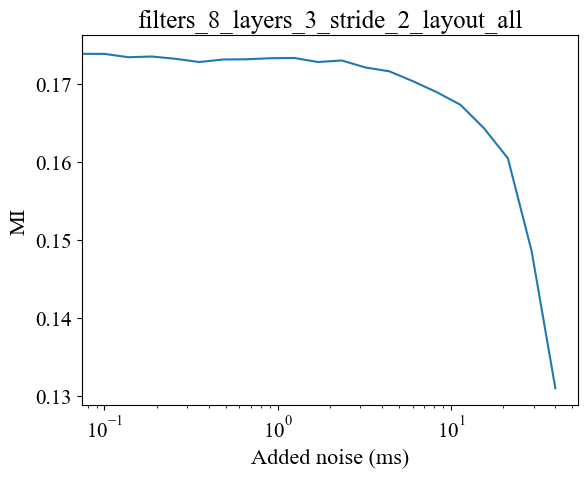

Train time = 1.0016369819641113
Test time = 0.08433103561401367
Epoch: 1, DSIB, test: 0.0334911085665226
Train time = 0.8862338066101074
Test time = 0.016330957412719727
Epoch: 2, DSIB, test: 0.05442921072244644
Train time = 0.8649759292602539
Test time = 0.017011165618896484
Epoch: 3, DSIB, test: 0.046967100352048874
Train time = 1.0087089538574219
Test time = 0.017080068588256836
Epoch: 4, DSIB, test: 0.06354910880327225
Train time = 0.8884391784667969
Test time = 0.016707897186279297
Epoch: 5, DSIB, test: 0.07112827897071838
Train time = 0.8764560222625732
Test time = 0.016488313674926758
Epoch: 6, DSIB, test: 0.07156440615653992
Train time = 0.879572868347168
Test time = 0.0169370174407959
Epoch: 7, DSIB, test: 0.060951001942157745
Train time = 0.8709559440612793
Test time = 0.01654195785522461
Epoch: 8, DSIB, test: 0.07864740490913391
Train time = 0.8821120262145996
Test time = 0.016827821731567383
Epoch: 9, DSIB, test: 0.07237760722637177
Train time = 0.9081830978393555
Test time

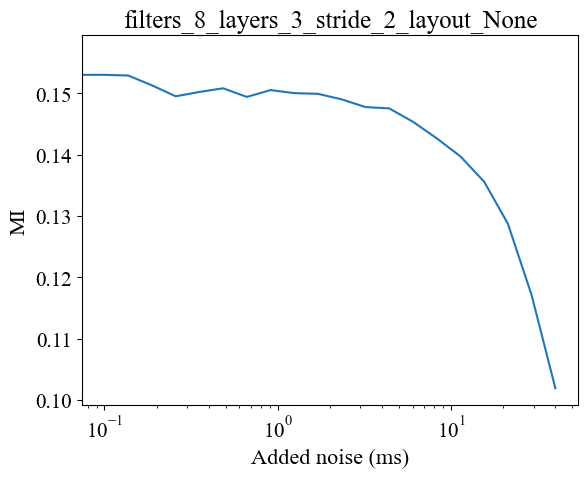

Train time = 1.3550691604614258
Test time = 0.0823979377746582
Epoch: 1, DSIB, test: 0.006476974114775658
Train time = 1.023967981338501
Test time = 0.06189107894897461
Epoch: 2, DSIB, test: 0.06707152724266052
Train time = 1.1265060901641846
Test time = 0.020305871963500977
Epoch: 3, DSIB, test: 0.04198301210999489
Train time = 1.069192886352539
Test time = 0.02312493324279785
Epoch: 4, DSIB, test: 0.07940936833620071
Train time = 0.9984190464019775
Test time = 0.021317005157470703
Epoch: 5, DSIB, test: 0.07384654879570007
Train time = 1.0492050647735596
Test time = 0.01980900764465332
Epoch: 6, DSIB, test: 0.07738342881202698
Train time = 0.9914376735687256
Test time = 0.020017147064208984
Epoch: 7, DSIB, test: 0.07519568502902985
Train time = 1.08784818649292
Test time = 0.018683910369873047
Epoch: 8, DSIB, test: 0.09414886683225632
Train time = 1.0079059600830078
Test time = 0.035156965255737305
Epoch: 9, DSIB, test: 0.10390620678663254
Train time = 1.0576560497283936
Test time = 0

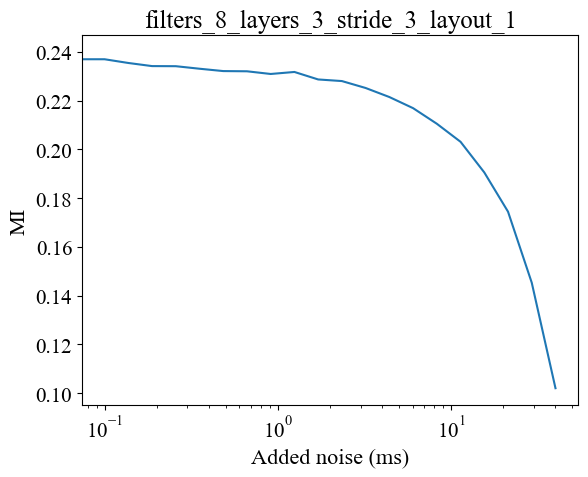

Train time = 1.658616065979004
Test time = 0.08719086647033691
Epoch: 1, DSIB, test: 0.004633109085261822
Train time = 1.3475100994110107
Test time = 0.035932064056396484
Epoch: 2, DSIB, test: 0.039008982479572296
Train time = 1.336467981338501
Test time = 0.034512996673583984
Epoch: 3, DSIB, test: 0.041705094277858734
Train time = 1.3740780353546143
Test time = 0.03082108497619629
Epoch: 4, DSIB, test: 0.051624152809381485
Train time = 1.3501880168914795
Test time = 0.03677630424499512
Epoch: 5, DSIB, test: 0.04414410516619682
Train time = 1.3466579914093018
Test time = 0.0291140079498291
Epoch: 6, DSIB, test: 0.06648264825344086
Train time = 1.3392131328582764
Test time = 0.03474116325378418
Epoch: 7, DSIB, test: 0.046606894582509995
Train time = 1.359222173690796
Test time = 0.02878284454345703
Epoch: 8, DSIB, test: 0.04685838147997856
Train time = 1.342824935913086
Test time = 0.03589892387390137
Epoch: 9, DSIB, test: 0.06767286360263824
Train time = 1.4172041416168213
Test time = 

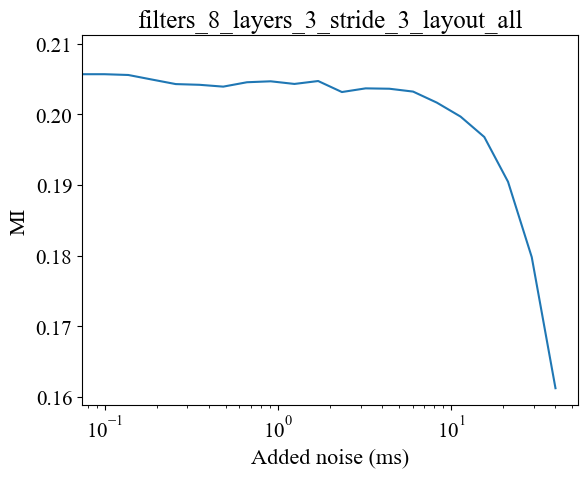

Train time = 0.8983142375946045
Test time = 0.01774311065673828
Epoch: 1, DSIB, test: 0.038123928010463715
Train time = 0.8635342121124268
Test time = 0.015287637710571289
Epoch: 2, DSIB, test: 0.06540378928184509
Train time = 0.8658576011657715
Test time = 0.016721248626708984
Epoch: 3, DSIB, test: 0.06246359646320343
Train time = 0.8994266986846924
Test time = 0.015352964401245117
Epoch: 4, DSIB, test: 0.07838231325149536
Train time = 0.8775360584259033
Test time = 0.014532089233398438
Epoch: 5, DSIB, test: 0.08350788056850433
Train time = 0.8830819129943848
Test time = 0.015671968460083008
Epoch: 6, DSIB, test: 0.07749994099140167
Train time = 0.886591911315918
Test time = 0.01379704475402832
Epoch: 7, DSIB, test: 0.09671108424663544
Train time = 0.878899335861206
Test time = 0.014747858047485352
Epoch: 8, DSIB, test: 0.09400095045566559
Train time = 0.8891549110412598
Test time = 0.013534784317016602
Epoch: 9, DSIB, test: 0.0931248739361763
Train time = 0.8759939670562744
Test time

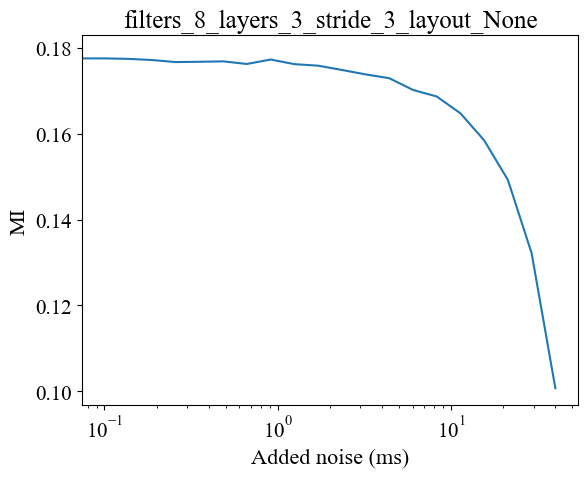

Train time = 1.4795591831207275
Test time = 0.07322502136230469
Epoch: 1, DSIB, test: -0.0008498088573105633
Train time = 1.225161075592041
Test time = 0.024430036544799805
Epoch: 2, DSIB, test: 0.027305880561470985
Train time = 1.1952869892120361
Test time = 0.02363896369934082
Epoch: 3, DSIB, test: 0.04299623519182205
Train time = 1.2220559120178223
Test time = 0.023988008499145508
Epoch: 4, DSIB, test: 0.049204323440790176
Train time = 1.2159531116485596
Test time = 0.024717092514038086
Epoch: 5, DSIB, test: 0.04348662123084068
Train time = 1.2427608966827393
Test time = 0.02243494987487793
Epoch: 6, DSIB, test: 0.044640202075242996
Train time = 1.2109968662261963
Test time = 0.024389028549194336
Epoch: 7, DSIB, test: 0.04258069768548012
Train time = 1.210101842880249
Test time = 0.0224151611328125
Epoch: 8, DSIB, test: 0.04564240574836731
Train time = 1.2357699871063232
Test time = 0.0223691463470459
Epoch: 9, DSIB, test: 0.058289431035518646
Train time = 1.261841058731079
Test tim

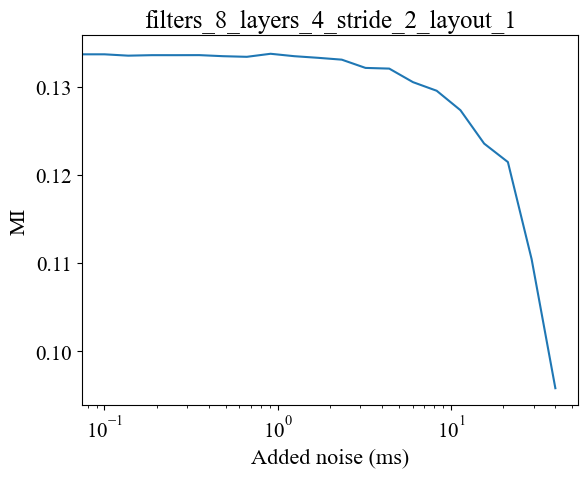

Train time = 1.7185170650482178
Test time = 0.07029104232788086
Epoch: 1, DSIB, test: 0.020322522148489952
Train time = 1.6030669212341309
Test time = 0.053894996643066406
Epoch: 2, DSIB, test: 0.042435746639966965
Train time = 1.6496901512145996
Test time = 0.05333399772644043
Epoch: 3, DSIB, test: 0.05284350365400314
Train time = 1.5673110485076904
Test time = 0.0599057674407959
Epoch: 4, DSIB, test: 0.05641871690750122
Train time = 1.544844150543213
Test time = 0.06144905090332031
Epoch: 5, DSIB, test: 0.07150895893573761
Train time = 1.799774169921875
Test time = 0.05413675308227539
Epoch: 6, DSIB, test: 0.06617386639118195
Train time = 1.5658822059631348
Test time = 0.05941891670227051
Epoch: 7, DSIB, test: 0.07263815402984619
Train time = 1.5783679485321045
Test time = 0.05236196517944336
Epoch: 8, DSIB, test: 0.0965508446097374
Train time = 1.6250009536743164
Test time = 0.05444598197937012
Epoch: 9, DSIB, test: 0.08782912790775299
Train time = 1.7191262245178223
Test time = 0.0

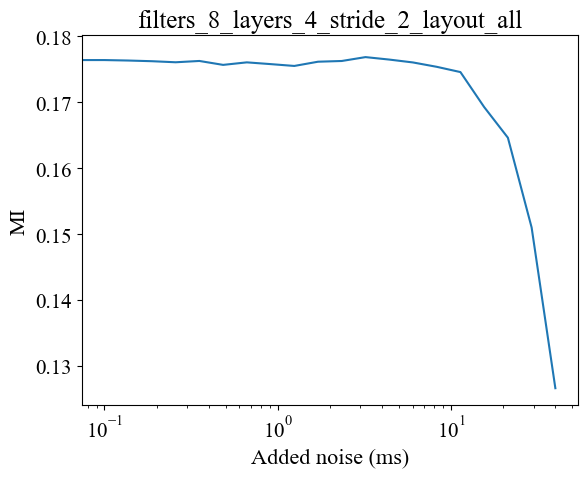

Train time = 0.9966590404510498
Test time = 0.05566692352294922
Epoch: 1, DSIB, test: 0.03138021007180214
Train time = 0.913780927658081
Test time = 0.016945838928222656
Epoch: 2, DSIB, test: 0.06560871750116348
Train time = 0.8881199359893799
Test time = 0.016755342483520508
Epoch: 3, DSIB, test: 0.06434202194213867
Train time = 0.9370901584625244
Test time = 0.01729893684387207
Epoch: 4, DSIB, test: 0.075543113052845
Train time = 0.9050979614257812
Test time = 0.017168045043945312
Epoch: 5, DSIB, test: 0.07222171127796173
Train time = 1.0209548473358154
Test time = 0.01682305335998535
Epoch: 6, DSIB, test: 0.09397077560424805
Train time = 0.9795100688934326
Test time = 0.019438982009887695
Epoch: 7, DSIB, test: 0.07757101207971573
Train time = 0.963191032409668
Test time = 0.018870830535888672
Epoch: 8, DSIB, test: 0.08847908675670624
Train time = 0.9465227127075195
Test time = 0.016742944717407227
Epoch: 9, DSIB, test: 0.0785682201385498
Train time = 0.9518420696258545
Test time = 0

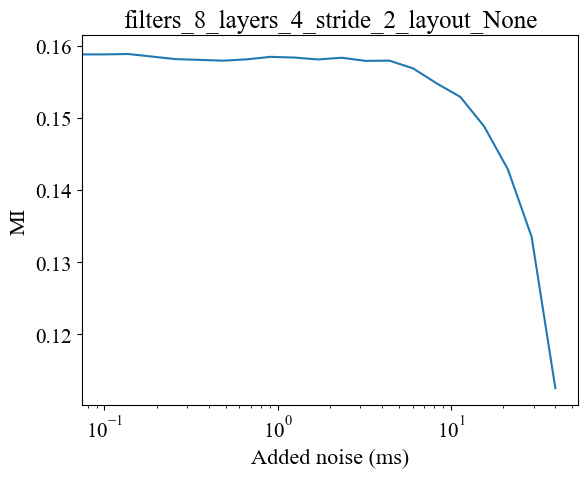

Train time = 1.2792932987213135
Test time = 0.04938316345214844
Epoch: 1, DSIB, test: 0.00042598816798999906
Train time = 1.0589587688446045
Test time = 0.026092052459716797
Epoch: 2, DSIB, test: 0.03288240730762482
Train time = 1.0864901542663574
Test time = 0.020225048065185547
Epoch: 3, DSIB, test: 0.053195927292108536
Train time = 1.0481171607971191
Test time = 0.034716129302978516
Epoch: 4, DSIB, test: 0.03772250935435295
Train time = 1.0679168701171875
Test time = 0.02339935302734375
Epoch: 5, DSIB, test: 0.05695628747344017
Train time = 1.0620408058166504
Test time = 0.024380922317504883
Epoch: 6, DSIB, test: 0.039398353546857834
Train time = 1.051985740661621
Test time = 0.025306224822998047
Epoch: 7, DSIB, test: 0.035923123359680176
Train time = 1.0632331371307373
Test time = 0.02368783950805664
Epoch: 8, DSIB, test: 0.05939934775233269
Train time = 1.0158107280731201
Test time = 0.05609703063964844
Epoch: 9, DSIB, test: 0.05883277207612991
Train time = 1.016672134399414
Test 

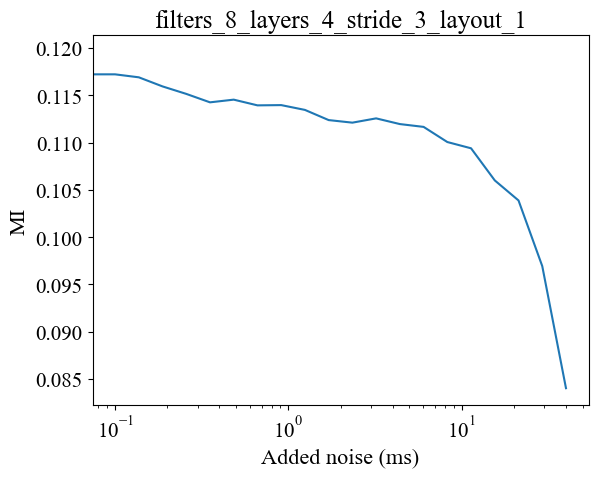

Train time = 1.6059579849243164
Test time = 0.06264781951904297
Epoch: 1, DSIB, test: 0.04781782627105713
Train time = 1.538423776626587
Test time = 0.04379391670227051
Epoch: 2, DSIB, test: 0.06312650442123413
Train time = 1.596426010131836
Test time = 0.04363822937011719
Epoch: 3, DSIB, test: 0.05819308012723923
Train time = 1.4393799304962158
Test time = 0.04039716720581055
Epoch: 4, DSIB, test: 0.05289879068732262
Train time = 1.5164649486541748
Test time = 0.04329395294189453
Epoch: 5, DSIB, test: 0.0718500092625618
Train time = 1.5351691246032715
Test time = 0.04539918899536133
Epoch: 6, DSIB, test: 0.06504900008440018
Train time = 1.5261259078979492
Test time = 0.04488396644592285
Epoch: 7, DSIB, test: 0.06303928047418594
Train time = 1.5022499561309814
Test time = 0.04165506362915039
Epoch: 8, DSIB, test: 0.0432124026119709
Train time = 1.457685947418213
Test time = 0.044184207916259766
Epoch: 9, DSIB, test: 0.05911220610141754
Train time = 1.5431287288665771
Test time = 0.0412

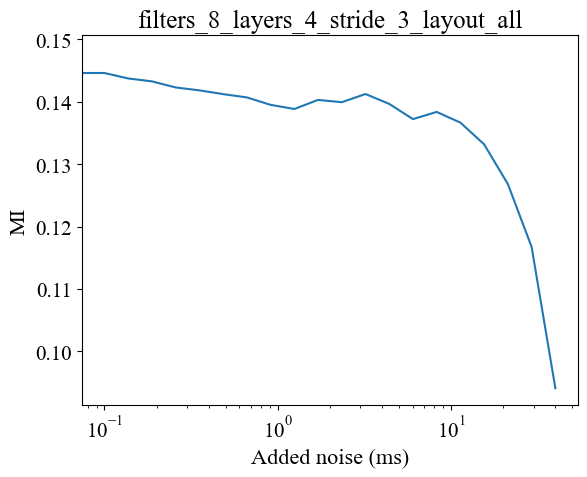

Train time = 1.1243619918823242
Test time = 0.02534008026123047
Epoch: 1, DSIB, test: 0.012739211320877075
Train time = 1.0107851028442383
Test time = 0.03233909606933594
Epoch: 2, DSIB, test: 0.03447076678276062
Train time = 1.1789941787719727
Test time = 0.016798973083496094
Epoch: 3, DSIB, test: 0.03711870312690735
Train time = 1.001162052154541
Test time = 0.01696300506591797
Epoch: 4, DSIB, test: 0.03412799909710884
Train time = 1.0739099979400635
Test time = 0.018568992614746094
Epoch: 5, DSIB, test: 0.014060823246836662
Train time = 1.0010759830474854
Test time = 0.018602848052978516
Epoch: 6, DSIB, test: -0.004515219479799271
Train time = 0.9984991550445557
Test time = 0.05508589744567871
Epoch: 7, DSIB, test: 0.04452001303434372
Train time = 0.9899740219116211
Test time = 0.01941990852355957
Epoch: 8, DSIB, test: 0.02716372348368168
Train time = 1.0734219551086426
Test time = 0.018815994262695312
Epoch: 9, DSIB, test: -0.009417013265192509
Train time = 1.0119750499725342
Test 

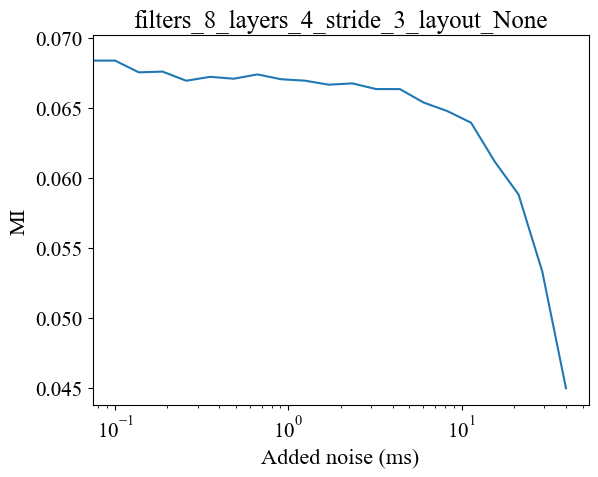

Train time = 1.4821500778198242
Test time = 0.05542564392089844
Epoch: 1, DSIB, test: -0.00713249621912837
Train time = 1.3246617317199707
Test time = 0.025419950485229492
Epoch: 2, DSIB, test: 0.041183799505233765
Train time = 1.3218629360198975
Test time = 0.02544093132019043
Epoch: 3, DSIB, test: 0.05825117975473404
Train time = 1.2906010150909424
Test time = 0.023495912551879883
Epoch: 4, DSIB, test: 0.06467617303133011
Train time = 1.330268144607544
Test time = 0.0239870548248291
Epoch: 5, DSIB, test: 0.028988812118768692
Train time = 1.2202203273773193
Test time = 0.022658824920654297
Epoch: 6, DSIB, test: 0.07370730489492416
Train time = 1.2105820178985596
Test time = 0.023964881896972656
Epoch: 7, DSIB, test: 0.07733423262834549
Train time = 1.1786940097808838
Test time = 0.025238037109375
Epoch: 8, DSIB, test: 0.09339501708745956
Train time = 1.2936031818389893
Test time = 0.03062295913696289
Epoch: 9, DSIB, test: 0.08359674364328384
Train time = 1.2905771732330322
Test time =

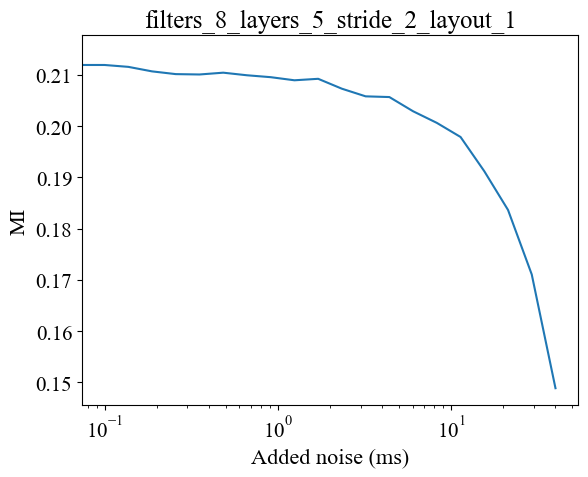

Train time = 1.897446870803833
Test time = 0.08370280265808105
Epoch: 1, DSIB, test: -0.0003147238749079406
Train time = 1.7886128425598145
Test time = 0.06099677085876465
Epoch: 2, DSIB, test: 0.030017487704753876
Train time = 1.7620768547058105
Test time = 0.06337189674377441
Epoch: 3, DSIB, test: 0.014301433227956295
Train time = 1.7637088298797607
Test time = 0.07291889190673828
Epoch: 4, DSIB, test: 0.03994641453027725
Train time = 1.825411081314087
Test time = 0.06543993949890137
Epoch: 5, DSIB, test: 0.060326650738716125
Train time = 1.8952877521514893
Test time = 0.06319713592529297
Epoch: 6, DSIB, test: 0.07604493945837021
Train time = 1.9615731239318848
Test time = 0.07056283950805664
Epoch: 7, DSIB, test: 0.00491503719240427
Train time = 1.9584510326385498
Test time = 0.06866598129272461
Epoch: 8, DSIB, test: 0.08979975432157516
Train time = 1.931102991104126
Test time = 0.06796383857727051
Epoch: 9, DSIB, test: 0.07955989241600037
Train time = 1.9260196685791016
Test time =

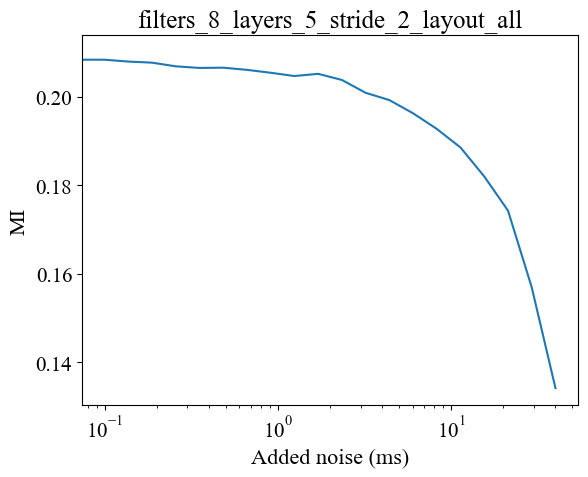

Train time = 1.1789512634277344
Test time = 0.02370905876159668
Epoch: 1, DSIB, test: 0.026637431234121323
Train time = 1.1072180271148682
Test time = 0.020186901092529297
Epoch: 2, DSIB, test: 0.04818575456738472
Train time = 1.16835618019104
Test time = 0.020004987716674805
Epoch: 3, DSIB, test: 0.07405313849449158
Train time = 1.2435400485992432
Test time = 0.02025604248046875
Epoch: 4, DSIB, test: 0.07964110374450684
Train time = 1.1038589477539062
Test time = 0.020383834838867188
Epoch: 5, DSIB, test: 0.0841643288731575
Train time = 1.1011807918548584
Test time = 0.020207881927490234
Epoch: 6, DSIB, test: 0.07664171606302261
Train time = 1.166172981262207
Test time = 0.01991105079650879
Epoch: 7, DSIB, test: 0.0842939168214798
Train time = 1.0796518325805664
Test time = 0.020694971084594727
Epoch: 8, DSIB, test: 0.11073557287454605
Train time = 1.117150068283081
Test time = 0.020430803298950195
Epoch: 9, DSIB, test: 0.1307065635919571
Train time = 1.1271998882293701
Test time = 0.

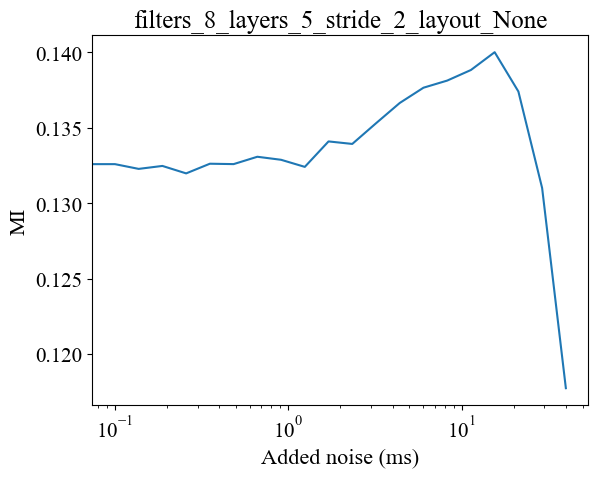

Train time = 1.411050796508789
Test time = 0.04914522171020508
Epoch: 1, DSIB, test: 0.0022899615578353405
Train time = 1.2292039394378662
Test time = 0.02265191078186035
Epoch: 2, DSIB, test: 0.018782546743750572
Train time = 1.2363381385803223
Test time = 0.027795791625976562
Epoch: 3, DSIB, test: 0.03517772629857063
Train time = 1.3262789249420166
Test time = 0.026896238327026367
Epoch: 4, DSIB, test: 0.026168351992964745
Train time = 1.2850840091705322
Test time = 0.02377009391784668
Epoch: 5, DSIB, test: -0.004309027921408415
Train time = 1.2548279762268066
Test time = 0.024713754653930664
Epoch: 6, DSIB, test: 0.03933422639966011
Train time = 1.3420147895812988
Test time = 0.02808213233947754
Epoch: 7, DSIB, test: 0.05866183340549469
Train time = 1.3278148174285889
Test time = 0.027591228485107422
Epoch: 8, DSIB, test: 0.05157573148608208
Train time = 1.3766038417816162
Test time = 0.025936126708984375
Epoch: 9, DSIB, test: 0.027023788541555405
Train time = 1.348775863647461
Test

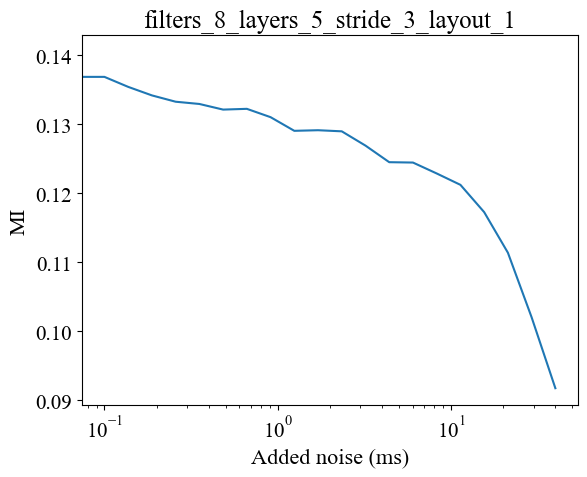

Train time = 1.8967068195343018
Test time = 0.06817221641540527
Epoch: 1, DSIB, test: 0.020275825634598732
Train time = 1.7384397983551025
Test time = 0.05941891670227051
Epoch: 2, DSIB, test: 0.04643918573856354
Train time = 1.7909328937530518
Test time = 0.05919194221496582
Epoch: 3, DSIB, test: 0.05676288157701492
Train time = 1.7923851013183594
Test time = 0.05861306190490723
Epoch: 4, DSIB, test: 0.06435576826334
Train time = 1.7575478553771973
Test time = 0.06050920486450195
Epoch: 5, DSIB, test: 0.030825313180685043
Train time = 1.7401838302612305
Test time = 0.05986213684082031
Epoch: 6, DSIB, test: 0.07823121547698975
Train time = 1.7595367431640625
Test time = 0.0689079761505127
Epoch: 7, DSIB, test: 0.08420763164758682
Train time = 1.9819140434265137
Test time = 0.06627726554870605
Epoch: 8, DSIB, test: 0.019090669229626656
Train time = 1.939518928527832
Test time = 0.05936002731323242
Epoch: 9, DSIB, test: 0.014971921220421791
Train time = 1.85780668258667
Test time = 0.060

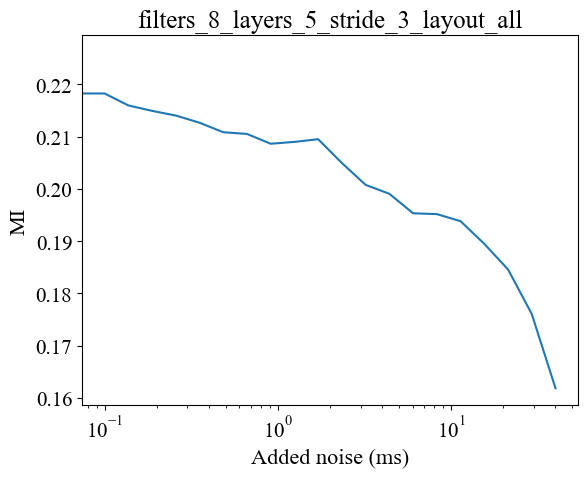

Train time = 1.1527659893035889
Test time = 0.025780916213989258
Epoch: 1, DSIB, test: 0.018906842917203903
Train time = 1.1355152130126953
Test time = 0.019096851348876953
Epoch: 2, DSIB, test: 0.011464837938547134
Train time = 1.081488847732544
Test time = 0.020776033401489258
Epoch: 3, DSIB, test: 0.006200242787599564
Train time = 1.1191627979278564
Test time = 0.023106098175048828
Epoch: 4, DSIB, test: 0.054162148386240005
Train time = 1.153113842010498
Test time = 0.019713163375854492
Epoch: 5, DSIB, test: 0.06809017807245255
Train time = 1.1369619369506836
Test time = 0.019814014434814453
Epoch: 6, DSIB, test: 0.04516611620783806
Train time = 1.2006189823150635
Test time = 0.020010948181152344
Epoch: 7, DSIB, test: 0.04309836030006409
Train time = 1.1499860286712646
Test time = 0.019030094146728516
Epoch: 8, DSIB, test: 0.0018696149345487356
Train time = 1.2995219230651855
Test time = 0.0203702449798584
Epoch: 9, DSIB, test: -0.002253188518807292
Train time = 1.1051971912384033
T

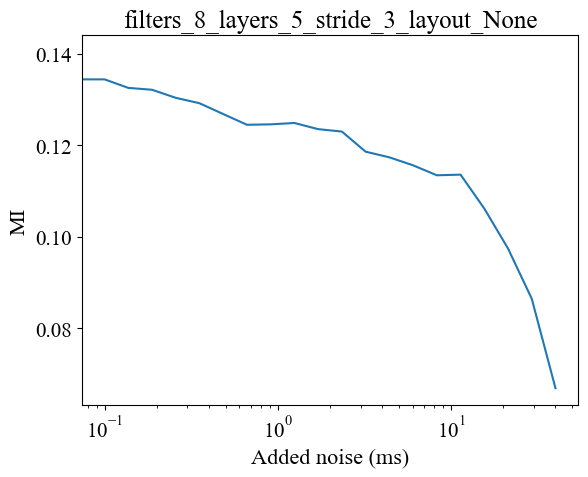

Train time = 1.328989028930664
Test time = 0.07057523727416992
Epoch: 1, DSIB, test: 0.0013617014046758413
Train time = 1.1447300910949707
Test time = 0.03429985046386719
Epoch: 2, DSIB, test: 0.017272165045142174
Train time = 1.1539359092712402
Test time = 0.03511190414428711
Epoch: 3, DSIB, test: -0.007000930141657591
Train time = 1.1333489418029785
Test time = 0.03603792190551758
Epoch: 4, DSIB, test: 0.03527553379535675
Train time = 1.1337687969207764
Test time = 0.029537200927734375
Epoch: 5, DSIB, test: 0.06363105773925781
Train time = 1.1523189544677734
Test time = 0.035540103912353516
Epoch: 6, DSIB, test: 0.09030159562826157
Train time = 1.1778922080993652
Test time = 0.034616947174072266
Epoch: 7, DSIB, test: 0.10068289190530777
Train time = 1.1671209335327148
Test time = 0.03205299377441406
Epoch: 8, DSIB, test: 0.1045626550912857
Train time = 1.1699647903442383
Test time = 0.03665900230407715
Epoch: 9, DSIB, test: 0.10219188034534454
Train time = 1.1760058403015137
Test tim

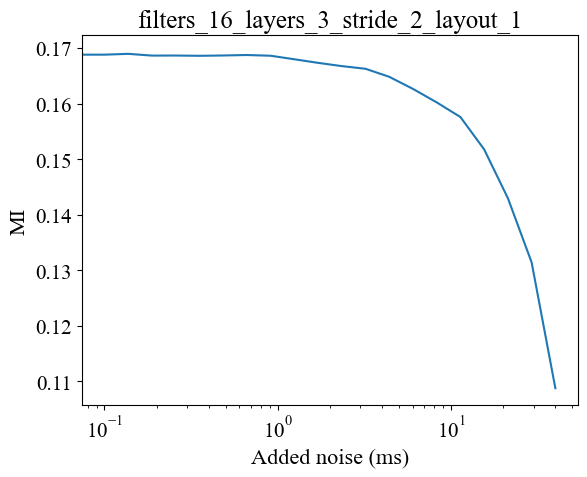

Train time = 1.5438849925994873
Test time = 0.0609588623046875
Epoch: 1, DSIB, test: 0.0043336814269423485
Train time = 1.3633332252502441
Test time = 0.03975105285644531
Epoch: 2, DSIB, test: 0.05419725924730301
Train time = 1.3827319145202637
Test time = 0.03805422782897949
Epoch: 3, DSIB, test: 0.07547804713249207
Train time = 1.3593559265136719
Test time = 0.0348973274230957
Epoch: 4, DSIB, test: 0.04144791513681412
Train time = 1.292281150817871
Test time = 0.03795790672302246
Epoch: 5, DSIB, test: 0.07910370826721191
Train time = 1.3119900226593018
Test time = 0.0349271297454834
Epoch: 6, DSIB, test: 0.07685781270265579
Train time = 1.318267822265625
Test time = 0.03947329521179199
Epoch: 7, DSIB, test: 0.06314096599817276
Train time = 1.3242638111114502
Test time = 0.03480195999145508
Epoch: 8, DSIB, test: 0.07847778499126434
Train time = 1.2901709079742432
Test time = 0.03798198699951172
Epoch: 9, DSIB, test: 0.07623882591724396
Train time = 1.296766996383667
Test time = 0.0347

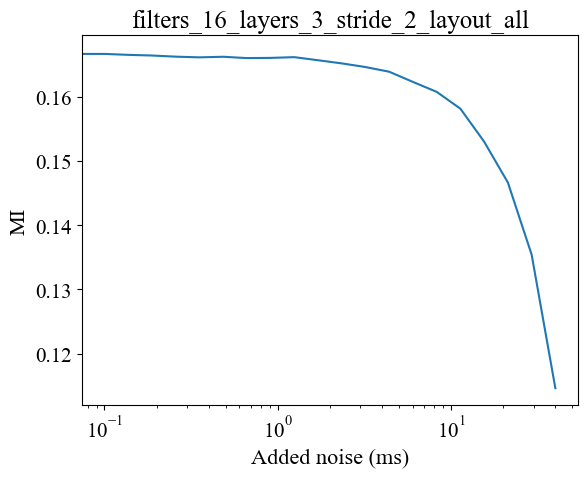

In [5]:
from itertools import product
filter_range = np.array([8, 16, 32])
layers_range = np.array([3,4,5])
stride_range = np.array([2,3])
branch_range = ['1', 'all', None]

precision_noise_levels = np.hstack((0, np.logspace(np.log10(period), np.log10(0.04), 20) / period))
n_repeats = 3

neuron = 25
dataset_neuron = BatchedDatasetWithNoise(X[[neuron],:].to(device), Y.to(device), params['window_size'])

train_ids = {}
precision_curves = {}
models = {}
time_per_epoch = {}

counter = 0
for n_filters, n_layers, n_stride, branch_layout in product(filter_range, layers_range, stride_range, branch_range):
    torch.mps.empty_cache()
    # Reset to zero noise
    dataset_neuron.apply_noise(0)
    # dataset_all.apply_noise(0)
    this_params = {**params, 'branch': branch_layout, 'stride': n_stride, 'n_filters': n_filters, 'layers': n_layers}
    # Train model on single neuron
    torch.mps.synchronize()
    tic = time.time()
    mis_test, train_id = train_cnn_model_no_eval(dataset_neuron, this_params, model_cache_dir)
    thistime = time.time() - tic
    mod = retrieve_best_model(model_cache_dir, mis_test, this_params, train_id=train_id)
    with torch.no_grad():
        # Estimate precision on this model
        precision_mi = np.zeros((len(precision_noise_levels), n_repeats))
        for j0,prec_noise_amp in enumerate(precision_noise_levels):
            for j1 in range(n_repeats):
                dataset_neuron.apply_noise(prec_noise_amp)
                precision_mi[j0,j1] = - mod(dataset_neuron.X, dataset_neuron.Y).detach().cpu().numpy()
        # Save results
        key = f'filters_{n_filters}_layers_{n_layers}_stride_{n_stride}_layout_{str(branch_layout)}'
        train_ids[key] = train_id
        models[key] = mod
        precision_curves[key] = precision_mi
        time_per_epoch[key] = thistime / len(mis_test)
        # Plot precision result
        fig, ax = plt.subplots()
        ax.plot(precision_noise_levels * period * 1000, np.mean(precision_mi, axis=1))
        ax.set_xscale('log')
        ax.set_xlabel('Added noise (ms)')
        ax.set_ylabel('MI')
        ax.set_title(key)
        plt.show()
        counter += 1
        if counter == 20:
            break


# Precision


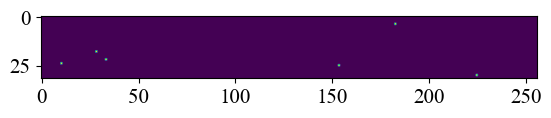

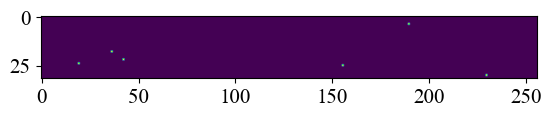

In [64]:
this_params = {**params, 'embed_dim': 10, 'batch_size': 256}
dataset = BatchedDatasetWithNoise(X.to(device), Y.to(device), this_params['batch_size'])

plt.figure()
dataset.apply_noise(0)
plt.imshow(dataset.Xnoise[0,0,:,:].cpu())
plt.figure()
dataset.apply_noise(0.001 / period)
plt.imshow(dataset.Xnoise[0,0,:,:].cpu())

In [ ]:
torch.cuda.empty_cache()
mod.eval()
amts = np.linspace(100,1500,10, dtype=int)
vals = np.zeros_like(amts)
with torch.no_grad():
    for i,amt in enumerate(amts):
        dataset.apply_noise(0)
        inds = np.random.choice(np.arange(dataset.Xnoise.shape[0]), amt)
        vals[i] = - mod(dataset.Xnoise[inds,:,:,:], dataset.Ynoise[inds,:,:,:])
plt.plot(amts, vals)

In [8]:
torch.mps.empty_cache()

# this_params = {**params, 'embed_dim': 10, 'window_size': 256}
torch.mps.synchronize()
tic = time.time()
dataset = BatchedDatasetWithNoise(X.to(device), Y.to(device), this_params['window_size'])
torch.mps.synchronize()
print(f'dataset = {time.time() - tic}')

n_repeats = 3
# noise_levels = torch.arange(period, 20*period, step=period).to(device)
noise_levels = torch.logspace(np.log10(period), np.log10(0.02), 20).to(device)
precision_mi = torch.zeros((len(noise_levels), n_repeats)).to(device)

mod.eval()

with torch.no_grad():
    for i,amp in enumerate(noise_levels):
        for j in range(n_repeats):
            dataset.apply_noise(amp / period)

            # inds = np.random.choice(np.arange(dataset.Xnoise.shape[0]), 2000)
            torch.mps.synchronize()
            tic = time.time()
            precision_mi[i,j] = -models[0](dataset.Xnoise, dataset.Ynoise).detach()
            torch.mps.synchronize()
            print(f'Inference: {time.time() - tic}')


dataset = 0.15633583068847656
Inference: 0.5941340923309326
Inference: 0.6205008029937744
Inference: 0.5042769908905029
Inference: 0.49620890617370605
Inference: 0.49607014656066895
Inference: 0.49566197395324707
Inference: 0.5053088665008545
Inference: 0.5037403106689453
Inference: 0.49646592140197754
Inference: 0.5309922695159912
Inference: 0.5017919540405273
Inference: 0.5031547546386719
Inference: 0.5056519508361816
Inference: 0.5065462589263916
Inference: 0.5328259468078613
Inference: 0.5059599876403809
Inference: 0.5154757499694824
Inference: 0.5013079643249512
Inference: 0.4972820281982422
Inference: 0.49623584747314453
Inference: 0.49387693405151367
Inference: 0.4951040744781494
Inference: 0.5004711151123047
Inference: 0.49389219284057617
Inference: 0.5356400012969971
Inference: 0.5194571018218994
Inference: 0.5167787075042725
Inference: 0.5145699977874756
Inference: 0.5240731239318848
Inference: 0.5170049667358398
Inference: 0.51226806640625
Inference: 0.5134811401367188
Infer

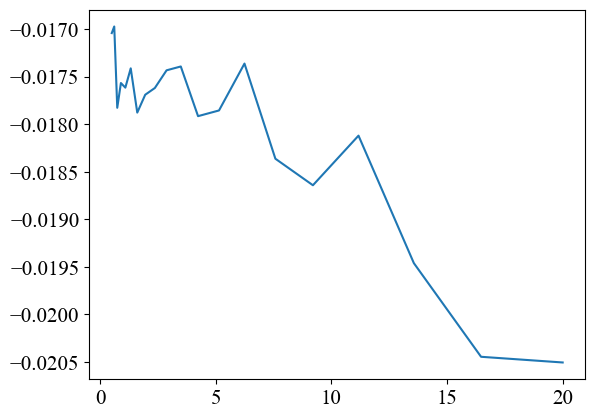

In [9]:
plt.plot(noise_levels.cpu() * 1000, torch.mean(precision_mi, dim=1).cpu())
# plt.gca().set_xscale('log')

# Precision estimation via training (not inference)

Re-training the model with different amounts of noise applied to the data

In [ ]:
params = {
    # Optimizer parameters (for training)
    'epochs': 250,
    'window_size': 256, # Window of time the estimator operates on, in samples
    'batch_size': 128, # Number of windows estimator processes at any time
    'learning_rate': 1e-3,
    'n_trials': 3,
    'patience': 30,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.9,
    # Critic parameters for DSIB or DVSIB (for the estimator), except embed_dim, which changes with training
    'model_func': DSIB, # DSIB or DVSIB
    'layers': 5,
    'fc_layers': 2, # fully connected layers, only for if using CNNs from data_form: 'image' 
    'hidden_dim': 512,
    'activation': nn.LeakyReLU, #nn.Softplus
    'beta': 512,
    'max_dz': 12, # max value for embed_dim that we search for
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'data_form': 'image',
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 1000, # If input has more than this many batches, encoder runs are split up for memory management
}

neuron = 25

period = 0.0005
noise_range = np.hstack((0, np.logspace(np.log10(period), np.log10(0.01), 10) / period))
mi = np.zeros_like(np.array(noise_range))
mi_test = []
models = []
ids = []
# Precision curve params
precision_noise_levels = np.hstack((0, np.logspace(np.log10(period), np.log10(0.04), 40) / period))
n_repeats = 5
precision_curves = []

X, Y, x_labels, y_labels = read_spike_data(os.path.join(data_dir, '2025-03-21'), period)
X, Y = torch.tensor(X, dtype=default_dtype), torch.tensor(Y, dtype=default_dtype)

for i,noise_amp in enumerate(noise_range):
    torch.mps.empty_cache()
    this_params = {**params, 'embed_dim': 10}
    dataset = BatchedDatasetWithNoise(X[[neuron],:].to(device), Y.to(device), this_params['window_size'])
    mis_test, train_id = train_cnn_model_no_eval_apply_noise(dataset, this_params, model_cache_dir, noise_amp)
    mod = retrieve_best_model(model_cache_dir, mis_test, this_params, train_id=train_id)
    # Store results
    mi_test.append(mis_test)
    models.append(mod)
    ids.append(train_id)
    # Run inference
    with torch.no_grad():
        dataset.apply_noise(noise_amp)
        thismi = - mod(dataset.Xnoise, dataset.Ynoise)
        mi[i] = thismi.detach().cpu()
        # Precision curve for each 
        precision_mi = np.zeros((len(precision_noise_levels), n_repeats))
        for j0,prec_noise_amp in enumerate(precision_noise_levels):
            for j1 in range(n_repeats):
                dataset.apply_noise(prec_noise_amp)
                precision_mi[j0,j1] = - mod(dataset.Xnoise, dataset.Ynoise).detach().cpu().numpy()
        precision_curves.append(precision_mi)


Train time = 1.280348777770996
Test time = 0.154494047164917
Epoch: 1, DSIB, test: 0.1166582778096199
Train time = 1.273681879043579
Test time = 0.04385209083557129
Epoch: 2, DSIB, test: 0.18439489603042603
Train time = 1.2437896728515625
Test time = 0.0436711311340332
Epoch: 3, DSIB, test: 0.1823572814464569
Train time = 1.2447450160980225
Test time = 0.04325294494628906
Epoch: 4, DSIB, test: 0.23784030973911285
Train time = 1.2418811321258545
Test time = 0.044243812561035156
Epoch: 5, DSIB, test: 0.2471899688243866
Train time = 1.244704008102417
Test time = 0.04499697685241699
Epoch: 6, DSIB, test: 0.20079758763313293
Train time = 1.2425282001495361
Test time = 0.04319000244140625
Epoch: 7, DSIB, test: 0.11532793939113617
Train time = 1.2433910369873047
Test time = 0.04400205612182617
Epoch: 8, DSIB, test: 0.14835144579410553
Train time = 1.2450592517852783
Test time = 0.044033050537109375
Epoch: 9, DSIB, test: -0.09854907542467117
Train time = 1.2392871379852295
Test time = 0.044008

Text(0, 0.5, 'MI (bits/s)')

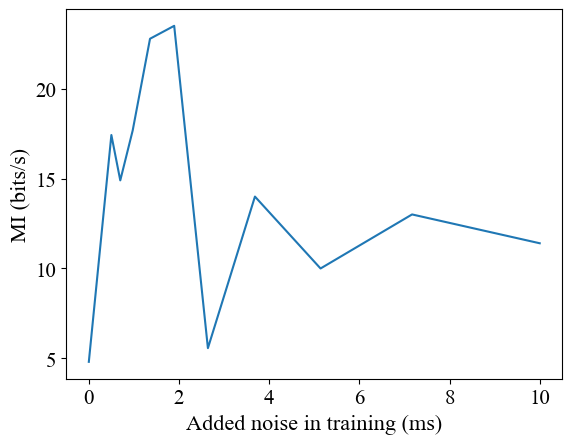

In [93]:
torch.mps.empty_cache()
plt.plot(noise_range * period * 1000, mi * np.log2(np.e) / params['window_size'] / period)
plt.gca().set_xlabel('Added noise in training (ms)')
plt.gca().set_ylabel('MI (bits/s)')

Text(0, 0.5, 'Measured precision (ms)')

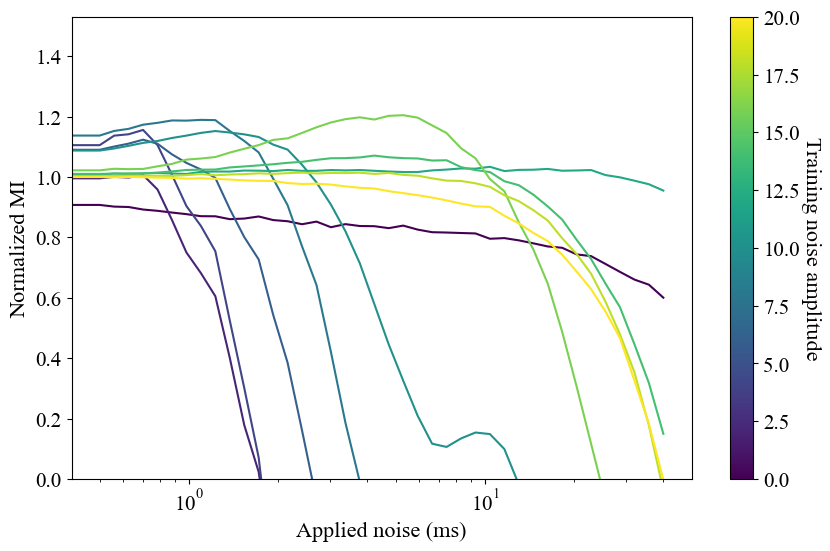

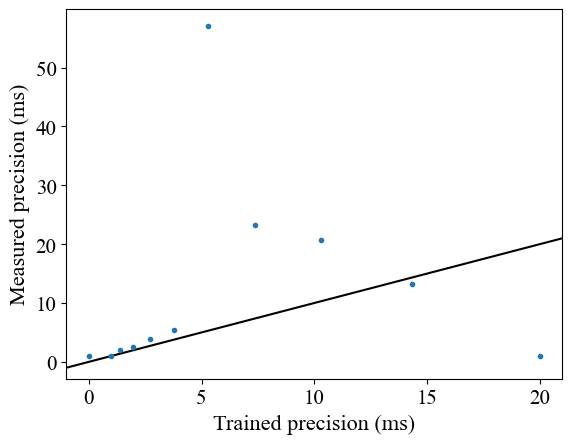

In [120]:
fig, ax = plt.subplots(figsize=(10, 6))
cmap = plt.cm.get_cmap('viridis')
for i in range(len(noise_range)):
    color_pos = i / (len(noise_range) - 1) if len(noise_range) > 1 else 0
    color = cmap(color_pos)
    vals = np.mean(precision_curves[i], axis=1) * np.log2(np.e) / params['window_size'] / period
    ax.plot(precision_noise_levels * period * 1000, vals / vals[0], color=color)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=noise_range[-1]))
sm.set_array([])  # Required for ScalarMappable
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Training noise amplitude', rotation=270, labelpad=15)
ax.set_xscale('log')
ax.set_ylim(0)
ax.set_xlabel('Applied noise (ms)')
ax.set_ylabel('Normalized MI')

fig, ax = plt.subplots()
precision = []
for curve in precision_curves:
    val = np.mean(curve, axis=1)
    val = val / val[0]
    precision.append(precision_noise_levels[np.argmax(val < 1)])

ax.axline([0,0], slope=1, color='k')
ax.plot(noise_range, np.array(precision),'.')
ax.set_xlabel('Trained precision (ms)')
ax.set_ylabel('Measured precision (ms)')

Text(0, 0.5, 'Normalized MI')

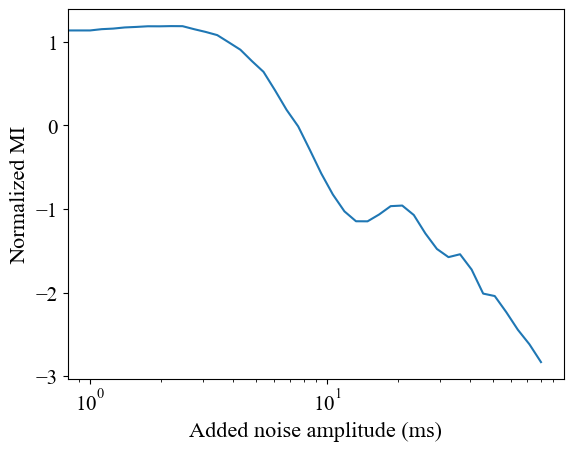

In [118]:
curve = np.mean(precision_curves[4], axis=1)
curve = curve / curve[0]
plt.plot(precision_noise_levels, curve)
curve
plt.gca().set_xscale('log')
plt.gca().set_xlabel('Added noise amplitude (ms)')
plt.gca().set_ylabel('Normalized MI')

# Vary dataset binning, see how it changes information learned/found

In [ ]:
params = {
    # Optimizer parameters (for training)
    'epochs': 250,
    'window_size': 512, # Window of time the estimator operates on, in samples
    'batch_size': 128, # Number of windows estimator processes at any time
    'learning_rate': 5e-3,
    'n_trials': 3,
    'patience': 15,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.9,
    # Critic parameters for DSIB or DVSIB (for the estimator), except embed_dim, which changes with training
    'model_func': DSIB, # DSIB or DVSIB
    'embed_dim': 10,
    'layers': 4,
    'fc_layers': 2, # fully connected layers, only for if using CNNs from data_form: 'image' 
    'hidden_dim': 512,
    'activation': nn.LeakyReLU, #nn.Softplus
    'beta': 512,
    'max_dz': 12, # max value for embed_dim that we search for
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'data_form': 'image',
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 1000, # If input has more than this many batches, encoder runs are split up for memory management
}

neuron = 25

period_range = np.logspace(np.log10(0.00005), np.log10(0.01), 20)
mi_test = []
models = []
ids = []
precision_noise_levels = np.hstack((0, np.logspace(np.log10(period), np.log10(0.04), 40) / period))
n_repeats = 3
precision_curves = []
for i,period in enumerate(period_range):
    print(f'Period = {period} s')
    X, Y, x_labels, y_labels = read_spike_data(os.path.join(data_dir, '2025-03-21'), period)
    X, Y = torch.tensor(X, dtype=default_dtype), torch.tensor(Y, dtype=default_dtype)
    torch.mps.empty_cache()
    dataset = BatchedDatasetWithNoise(X[[neuron],:].to(device), Y.to(device), params['window_size'])
    mis_test, train_id = train_cnn_model_no_eval(dataset, params, model_cache_dir)
    mod = retrieve_best_model(model_cache_dir, mis_test, train_id=train_id, burn_in=1)
    # Store results
    mi_test.append(mis_test)
    models.append(mod)
    ids.append(train_id)
    with torch.no_grad():
        # Precision curve for each 
        precision_mi = np.zeros((len(precision_noise_levels), n_repeats))
        for j0,prec_noise_amp in enumerate(precision_noise_levels):
            for j1 in range(n_repeats):
                dataset.apply_noise(prec_noise_amp)
                precision_mi[j0,j1] = - mod(dataset.Xnoise, dataset.Ynoise).detach().cpu().numpy()
        precision_curves.append(precision_mi)


Period = 4.9999999999999996e-05 s
Train time = 8.385380744934082
Test time = 0.21169400215148926
Epoch: 1, DSIB, test: 0.006829846650362015
Train time = 7.9879150390625
Test time = 0.2163081169128418
Epoch: 2, DSIB, test: 0.03982722386717796
Train time = 7.946149826049805
Test time = 0.2069230079650879
Epoch: 3, DSIB, test: 0.03663326054811478
Train time = 7.95436692237854
Test time = 0.20759916305541992
Epoch: 4, DSIB, test: 0.04140667989850044
Train time = 7.903834342956543
Test time = 0.20545005798339844
Epoch: 5, DSIB, test: 0.04298585280776024
Train time = 7.910940885543823
Test time = 0.2080216407775879
Epoch: 6, DSIB, test: 0.03641291707754135
Train time = 7.91900110244751
Test time = 0.20574522018432617
Epoch: 7, DSIB, test: 0.03459368646144867
Train time = 7.93487286567688
Test time = 0.2082958221435547
Epoch: 8, DSIB, test: 0.035471778362989426
Train time = 7.982103109359741
Test time = 0.20671892166137695
Epoch: 9, DSIB, test: 0.04286494106054306
Train time = 7.9067850112915

In [32]:
n_repeats = 3
precision_curves = []
for i,period in enumerate(period_range):
    with torch.no_grad():
        X, Y, x_labels, y_labels = read_spike_data(os.path.join(data_dir, '2025-03-21'), period)
        X, Y = torch.tensor(X, dtype=default_dtype), torch.tensor(Y, dtype=default_dtype)
        torch.mps.empty_cache()
        precision_noise_levels = np.hstack((0, np.logspace(np.log10(period), np.log10(0.04), 40) / period))
        # Precision curve for each 
        precision_mi = np.zeros((len(precision_noise_levels), n_repeats))
        for j0,prec_noise_amp in enumerate(precision_noise_levels):
            for j1 in range(n_repeats):
                dataset.apply_noise(prec_noise_amp)
                precision_mi[j0,j1] = - models[i](dataset.Xnoise, dataset.Ynoise).detach().cpu().numpy()
        precision_curves.append(precision_mi)

Text(0, 0.5, 'MI (bits/s)')

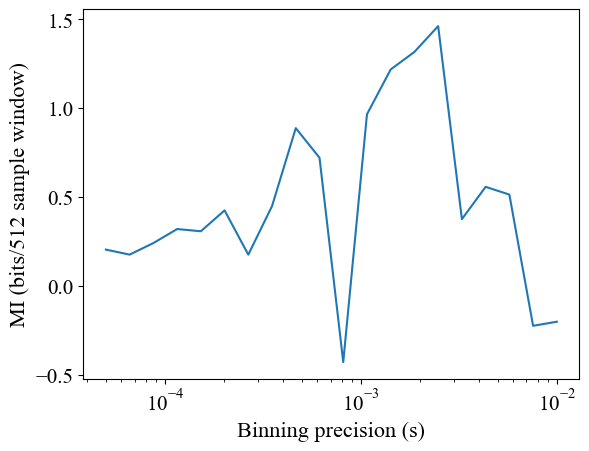

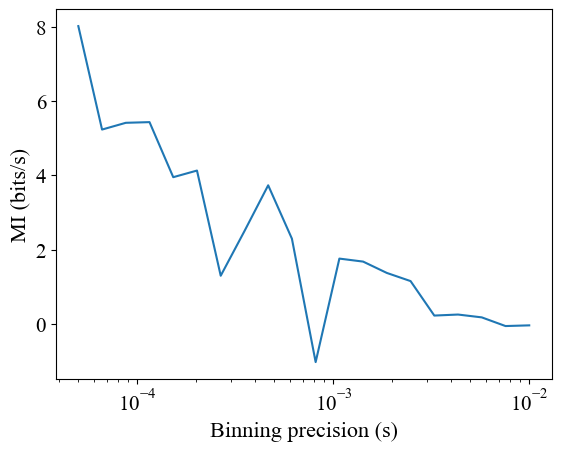

In [19]:
mi = np.array([np.mean(p[0,:]) for p in precision_curves])
plt.plot(np.array(period_range), mi * np.log2(np.e))
ax = plt.gca()
ax.set_xscale('log')
ax.set_xlabel('Binning precision (s)')
ax.set_ylabel('MI (bits/512 sample window)')

plt.figure()
plt.plot(np.array(period_range), mi * np.log2(np.e) / params['window_size'] / period_range)
ax = plt.gca()
ax.set_xscale('log')
ax.set_xlabel('Binning precision (s)')
ax.set_ylabel('MI (bits/s)')

In [42]:
period_range * 1000

array([ 0.05      ,  0.06608104,  0.08733407,  0.11542251,  0.15254479,
        0.20160635,  0.26644714,  0.35214206,  0.46539824,  0.61507997,
        0.81290243,  1.07434871,  1.41988152,  1.87654485,  2.48008057,
        3.2777259 ,  4.33191049,  5.7251427 ,  7.56646728, 10.        ])

Text(0, 0.5, 'Normalized MI')

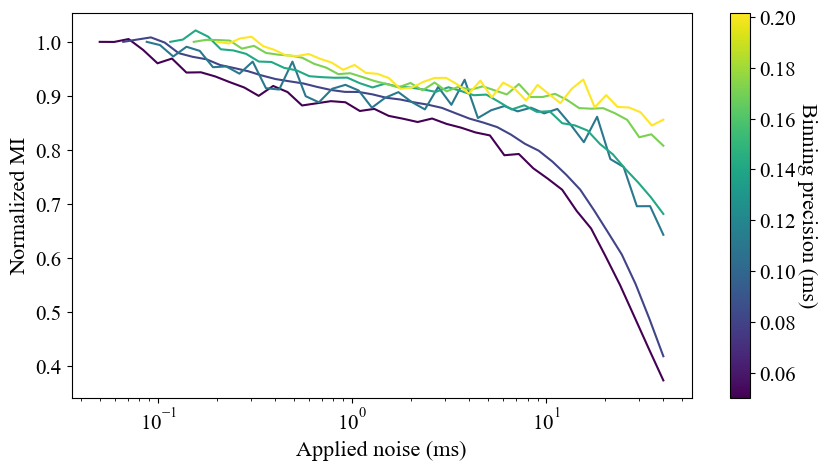

In [55]:
fig, ax = plt.subplots(figsize=(10,5))
cmap = plt.cm.get_cmap('viridis')
prange = period_range[0:6]
for i, period in enumerate(prange):
    precision_noise_levels = np.hstack((0, np.logspace(np.log10(period), np.log10(0.04), 40)))
    color_pos = i / (len(prange) - 1) if len(prange) > 1 else 0
    color = cmap(color_pos)
    vals = np.mean(precision_curves[i], axis=1) * np.log2(np.e) / params['window_size'] / period
    ax.plot(precision_noise_levels[1:] * 1000, vals[1:] / vals[1], color=color)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=prange[0]*1000, vmax=prange[-1]*1000))
sm.set_array([])  # Required for ScalarMappable
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Binning precision (ms)', rotation=270, labelpad=15)
ax.set_xscale('log')
# ax.set_ylim()
ax.set_xlabel('Applied noise (ms)')
ax.set_ylabel('Normalized MI')

Text(0, 0.5, 'Normalized MI')

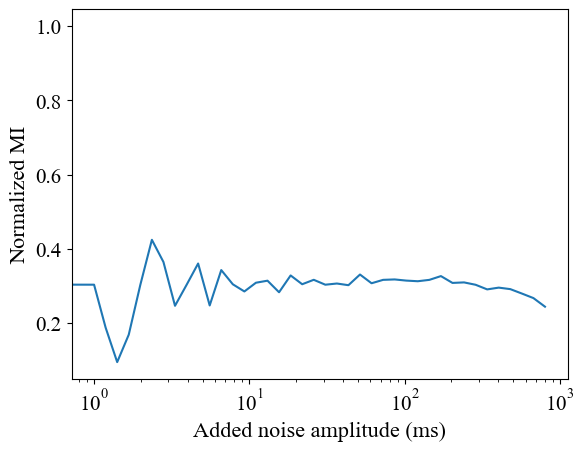

In [18]:
curve = np.mean(precision_curves[0], axis=1)
curve = curve / curve[0]
plt.plot(precision_noise_levels, curve)
curve
plt.gca().set_xscale('log')
plt.gca().set_xlabel('Added noise amplitude (ms)')
plt.gca().set_ylabel('Normalized MI')

In [26]:
from tqdm.auto import tqdm
# Empty arrays and do the run, will take forever
mi = {}
mi_test = {}
models = {}
ids = {}
batch_size_range = np.array([128, 256, 512, 1024])
neuron = np.random.choice(X.shape[0])

for bs in batch_size_range:
    for dz in tqdm(range(1, params['max_dz']+1)):
        print(f'Starting dz = {dz}')
        for j in range(params['n_trials']):
            this_params = {**params, 'embed_dim': dz, 'batch_size': bs}
            print(f'batch size = {bs}, dz = {dz}, trial = {j+1}')
            torch.cuda.empty_cache()
            dataset = BatchedDataset(X[[neuron],:], Y, this_params['batch_size'])
            full_dataset = create_cnn_data_split(dataset, 60, train_fraction=0.9, eval_fraction=0.9, device=device)
            mis, mis_test, _ = train_cnn_model(DSIB, full_dataset, this_params)
            # full_dataset = create_cnn_data_split(dataset, train_fraction=0.9, eval_fraction=0.9, device=device)
            # mis, mis_test = train_model(DSIB, full_dataset, this_params)
            # mis_test, train_id = train_model_no_eval(DSIB, full_dataset, this_params, model_cache_dir)
            # mod = retrieve_best_model(model_cache_dir, mis_test, train_id=train_id, burn_in=1)
            # Store results
            key = f"trial_{j}_dz_{dz}_bs_{bs}"
            mi[key] = mis
            mi_test[key] = mis_test
            # models[key] = mod
            # ids[key] = train_id
torch.cuda.empty_cache()


  0%|          | 0/12 [00:00<?, ?it/s]

Starting dz = 1
batch size = 128, dz = 1, trial = 1
Train time = 0.7406737804412842
Eval time = 0.016013622283935547
Test time = 0.005005598068237305
Epoch: 1, DSIB, train: -8.574826097174082e-06, test: -8.78915216162568e-06
Train time = 0.5104649066925049
Eval time = 0.002001047134399414
Test time = 0.002002716064453125
Epoch: 2, DSIB, train: -3.644090156740276e-06, test: -3.7664101455447963e-06
Train time = 0.5234763622283936
Eval time = 0.002001523971557617
Test time = 0.002003192901611328
Epoch: 3, DSIB, train: -1.7990419109992217e-06, test: -2.378149929427309e-06
Train time = 0.5004549026489258
Eval time = 0.002001523971557617
Test time = 0.002003192901611328
Epoch: 4, DSIB, train: -1.598914082023839e-06, test: -1.5391580063806032e-06
Train time = 0.5214755535125732
Eval time = 0.002002716064453125
Test time = 0.001001119613647461
Epoch: 5, DSIB, train: -8.14888323930063e-07, test: -1.0640453638188774e-06
Train time = 0.5054595470428467
Eval time = 0.002002716064453125
Test time =

  0%|          | 0/12 [00:00<?, ?it/s]

Starting dz = 1
batch size = 256, dz = 1, trial = 1
Train time = 0.43439412117004395
Eval time = 0.01401376724243164
Test time = 0.005004405975341797
Epoch: 1, DSIB, train: -0.00040275955689139664, test: -0.00039908778853714466
Train time = 0.45641469955444336
Eval time = 0.002002239227294922
Test time = 0.0009999275207519531
Epoch: 2, DSIB, train: -2.252435115224216e-05, test: -2.9693497708649375e-05
Train time = 0.4253857135772705
Eval time = 0.0020024776458740234
Test time = 0.002001047134399414
Epoch: 3, DSIB, train: -3.789873744608485e-06, test: -5.052479991718428e-06
Train time = 0.42738842964172363
Eval time = 0.0020017623901367188
Test time = 0.003002643585205078
Epoch: 4, DSIB, train: -1.6487376797158504e-06, test: -1.6182557374122553e-06
Train time = 0.4263877868652344
Eval time = 0.002187490463256836
Test time = 0.0010008811950683594
Epoch: 5, DSIB, train: -1.8684459064388648e-06, test: -1.3424544249573955e-06
Train time = 0.4133765697479248
Eval time = 0.002000570297241211


  0%|          | 0/12 [00:00<?, ?it/s]

Starting dz = 1
batch size = 512, dz = 1, trial = 1
Train time = 0.6295723915100098
Eval time = 0.016015052795410156
Test time = 0.007005929946899414
Epoch: 1, DSIB, train: -0.01148455310612917, test: -0.01034874189645052
Train time = 0.6191556453704834
Eval time = 0.0030028820037841797
Test time = 0.0020017623901367188
Epoch: 2, DSIB, train: -0.00048147584311664104, test: -0.00042977623525075614
Train time = 0.6265697479248047
Eval time = 0.0020020008087158203
Test time = 0.0010004043579101562
Epoch: 3, DSIB, train: -6.341320113278925e-05, test: -6.500879680970684e-05
Train time = 0.6385796070098877
Eval time = 0.0020020008087158203
Test time = 0.0020020008087158203
Epoch: 4, DSIB, train: -1.6865586076164618e-05, test: -1.9105924366158433e-05
Train time = 0.6155598163604736
Eval time = 0.002002239227294922
Test time = 0.0020017623901367188
Epoch: 5, DSIB, train: -1.0816255780810025e-05, test: -1.3565530025516637e-05
Train time = 0.6215651035308838
Eval time = 0.0020024776458740234
Tes

  0%|          | 0/12 [00:00<?, ?it/s]

Starting dz = 1
batch size = 1024, dz = 1, trial = 1
Train time = 0.5445020198822021
Eval time = 0.020017385482788086
Test time = 0.00600433349609375
Epoch: 1, DSIB, train: -0.012846967205405235, test: -0.01035755593329668
Train time = 0.5034575462341309
Eval time = 0.0020012855529785156
Test time = 0.002001523971557617
Epoch: 2, DSIB, train: -0.005014576483517885, test: -0.00434390502050519
Train time = 0.5044593811035156
Eval time = 0.0030014514923095703
Test time = 0.002002716064453125
Epoch: 3, DSIB, train: -0.0008515996159985662, test: -0.0006777612725272775
Train time = 0.5054595470428467
Eval time = 0.0020017623901367188
Test time = 0.002001523971557617
Epoch: 4, DSIB, train: -8.7614098447375e-05, test: -7.642570562893525e-05
Train time = 0.5024571418762207
Eval time = 0.0020017623901367188
Test time = 0.001001119613647461
Epoch: 5, DSIB, train: -5.419558874564245e-06, test: -4.655436441680649e-06
Train time = 0.5024561882019043
Eval time = 0.002001523971557617
Test time = 0.002

KeyError: 'trial_0_dz_1_bs_20'

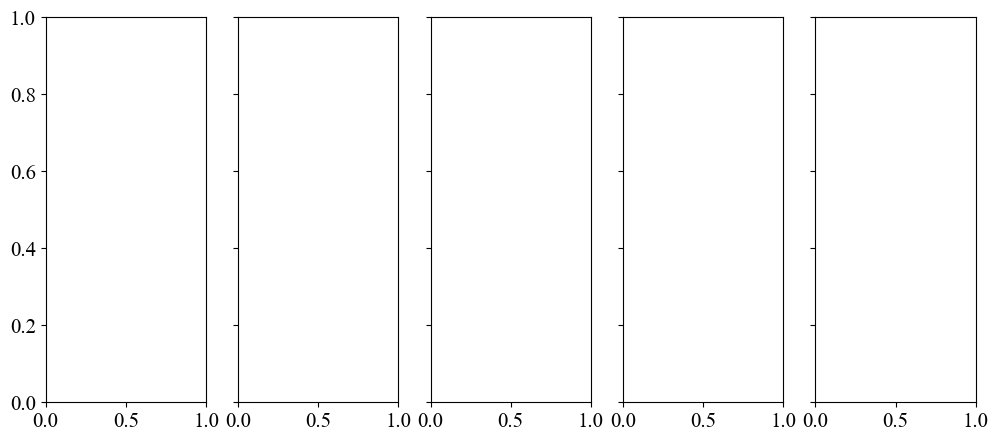

In [34]:
# Define sigma, a small number is usually the best choice
sigma=1 # (or 2 at most)

fig, ax = plt.subplots(1, len(batch_size_range), figsize=(12,5), sharey=True)
for i,bs in enumerate(batch_size_range):    
    dz_means, dz_stds = [], []
    dz_train_means, dz_train_stds = [], []
    for dz in range(1, params['max_dz']+1):
        mi_trials = []
        mi_train = []
        for j in range(params['n_trials']):
            key = f"trial_{j}_dz_{dz}_bs_{bs}"
            # Convert Nan to zeros and smooth
            # test = gaussian_filter1d(np.nan_to_num(mi_test[key]), sigma=sigma) / bs * np.log2(np.e) * 1000
            train = gaussian_filter1d(np.nan_to_num(mi[key]), sigma=sigma) * np.log2(np.e) #/ (0.0005 * bs)
            test = gaussian_filter1d(np.nan_to_num(mi_test[key]), sigma=sigma) * np.log2(np.e) #/ (0.0005 * bs)
            # Pick the epoch with highest test value and get corresponding train
            best = np.argmax(test)
            mi_trials.append(test[best])
            mi_train.append(train[best])
        dz_means.append(np.mean(np.array(mi_trials)).flatten())
        dz_stds.append(np.std(np.array(mi_trials)).flatten())
        dz_train_means.append(np.mean(np.array(mi_train)).flatten())
        dz_train_stds.append(np.std(np.array(mi_train)).flatten())
    b = ax[i].errorbar(
        range(1, params['max_dz']+1), np.array(dz_means).flatten(), 
        yerr=np.array(dz_stds).flatten(), 
        fmt='s:', capsize=4)
    # ax[i].errorbar(
    #     range(1, params['max_dz']+1), np.array(dz_train_means).flatten(), 
    #     yerr=np.array(dz_train_stds).flatten(), 
    #     fmt='s:', capsize=4)

    # Set title and scales
    ax[i].set_title(str(bs))
    ax[i].set_xlabel(r'$dz$')
    if i == 0:
        ax[i].set_ylabel(r'$I(X;Y) \text{(bits/s)}$');
    # ax[i].set_ylim(-1, 4)


trial_0_dz_10_bs_64


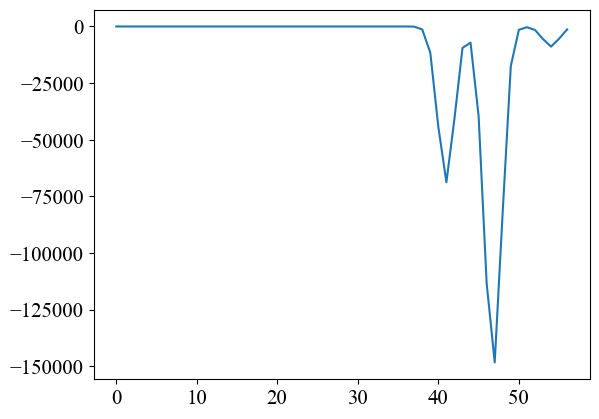

In [72]:
key = random.choice(list(mi_test.keys()))
sigma = 1
# plt.plot(gaussian_filter1d(np.nan_to_num(mi[key]), sigma=sigma))
plt.plot(gaussian_filter1d(np.nan_to_num(mi_test[key]) * np.log2(np.e), sigma=sigma))
# plt.gca().set_ylim(0)
print(key)

In [82]:
import pickle

with open(os.path.join(main_dir, 'mi_test_2025-04-27.pkl'), 'wb') as f:
    pickle.dump(mi_test, f)
with open(os.path.join(main_dir, 'ids_2025-04-27.pkl'), 'wb') as f:
    pickle.dump(ids, f)


In [91]:
ids

{'trial_0_dz_5_bs_64': 'DSIB_dz-5_bs-64_8fd6f693-0e8c-4050-80f0-71743727faf4',
 'trial_1_dz_5_bs_64': 'DSIB_dz-5_bs-64_53c1ac4c-c23f-4fb7-b0de-03609854555d',
 'trial_2_dz_5_bs_64': 'DSIB_dz-5_bs-64_980c7b88-ae7e-45c8-8654-43988f324259',
 'trial_0_dz_6_bs_64': 'DSIB_dz-6_bs-64_f5780180-bfd3-435e-b811-ea7695d4a1b5',
 'trial_1_dz_6_bs_64': 'DSIB_dz-6_bs-64_bd177624-0f1d-47e3-9b66-3efe1affcb26',
 'trial_2_dz_6_bs_64': 'DSIB_dz-6_bs-64_e444d9e9-1f41-4509-8b87-95f2bcb4c6ba',
 'trial_0_dz_7_bs_64': 'DSIB_dz-7_bs-64_9dc5f773-c58a-41b1-8d58-f154bc18fe83',
 'trial_1_dz_7_bs_64': 'DSIB_dz-7_bs-64_136f4efa-0772-4a42-b8d1-163fcca65eda',
 'trial_2_dz_7_bs_64': 'DSIB_dz-7_bs-64_aa666a3e-dd74-47c8-9e75-a2260fe347af',
 'trial_0_dz_8_bs_64': 'DSIB_dz-8_bs-64_aaf1e6a7-8d80-4aba-bfe0-8fc840cb522f',
 'trial_1_dz_8_bs_64': 'DSIB_dz-8_bs-64_ef96a2d7-2bcc-45d7-b9ec-20ad29bfc0a7',
 'trial_2_dz_8_bs_64': 'DSIB_dz-8_bs-64_b53fd0ff-c038-4b42-b96d-2a9a32ea69e8',
 'trial_0_dz_9_bs_64': 'DSIB_dz-9_bs-64_6ce81eb9-0f7

In [ ]:
with open(os.path.join(main_dir, 'mi_test_2025-04-27.pkl'), 'rb') as f:
    bob = pickle.load(f)
with open(os.path.join(main_dir, 'ids_2025-04-27.pkl'), 'rb') as f:
    bob = pickle.load(f)

Okay, so running on the whole dataset takes a long time. 


Scheme for a given moth:
- X embedding dimension sizes
- Y repeats at each embedding dim size
- Z batch sizes